# FER Transfer on FERG dataset using Norm-reference encoding

The goal is to train the NR mechanism using BFS's Louise and applied to the different heads shapes from the FERG dataset

## import

In [1]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.patches import compute_center_of_activity
from utils.calculate_position import calculate_position
from models.NormBase import NormBase

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

## Set Parameters

In [2]:
# define configuration
config_path = 'NR_06_FER_transfer_on_FERG_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

## Load extraction pipeline

In [3]:
# load and define extraction model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1Metal device set to: Apple M1 Pro
 Physical GPUs, 1 Logical GPUs


2022-07-06 11:51:46.435048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-06 11:51:46.435176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


## load training data

In [4]:
# load the training data to train the RBF templates: Louise and Merry neutral frame
data = load_data(config)
n_training = len(data[0])
print("[LOAD] Training Data loaded", np.shape(data[0]))
print("[LOAD] Labels Data loaded", np.shape(data[1]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 2/2 [00:00<00:00, 194.46it/s]

[LOAD] Training Data loaded (2, 224, 224, 3)
[LOAD] Labels Data loaded (2,)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


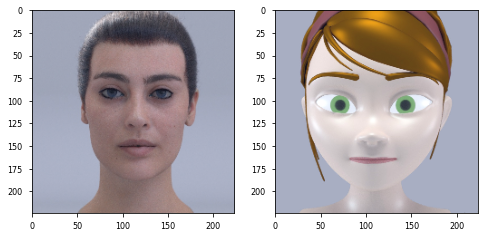

In [5]:
# plot the pre-processed images to see how the training data looks like
plt.figure(figsize=(4*n_training, 4))
for i in range(n_training):
    plt.subplot(1, n_training, i + 1)
    img = np.array(data[0][i])
    rgb_img = img[..., ::-1]
    norm_img = (rgb_img + 127.5) / 256
    plt.imshow(norm_img)

## Predict with extraction pipeline

In [6]:
def predict_v4(data):
    # predict v4 output
    preds = v4_model.predict(data[0], verbose=1)
    print("[TRAIN] shape prediction", np.shape(preds))

    # get feature maps that mimic a semantic selection pipeline
    # keep only highest IoU semantic score
    eyebrow_preds = preds[..., config['best_eyebrow_IoU_ft']]
    print("shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
    lips_preds = preds[..., config['best_lips_IoU_ft']]
    print("shape lips semantic feature selection", np.shape(lips_preds))
    preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
    print("[TRAIN] shape preds", np.shape(preds))

    return preds

In [7]:
preds = predict_v4(data)

1/1 [==============================] - 0s 83ms/step
[TRAIN] shape prediction (2, 56, 56, 256)
shape eyebrow semantic feature selection (2, 56, 56, 2)
shape lips semantic feature selection (2, 56, 56, 16)
[TRAIN] shape preds (2, 56, 56, 18)


2022-07-06 11:51:50.220073: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-06 11:51:50.262181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Train and detect facial identity (Facial Recognition)

### Build RBF templates

In [8]:
def get_templates(preds, sigmas, rbfs, threshold=0.25, masks=None, zeros=None, verbose=False):
    # create FR templates
    templates = []
    rbf_templates = []
    patterns = []

    for i in range(len(preds)):
        config['rbf_sigma'] = config[sigmas[i]]
        rbf_template = np.array(config[rbfs[i]])

        mask = None
        zero = None
        if masks is not None:
            mask = np.array(config[masks[i]])
        if zero is not None:
            zero = np.array(config[zeros[i]])

        pattern = PatternFeatureSelection(config, template=rbf_template, mask=mask, zeros=zero)

        # fit template
        neutral_preds = np.expand_dims(preds[i], axis=0)
        template_preds = np.repeat(np.expand_dims(neutral_preds, axis=0), len(rbf_template), axis=0)
        template = pattern.fit(template_preds)
        template[template < threshold] = 0

        templates.append(template[0])
        rbf_templates.append(rbf_template)
        patterns.append(pattern)

    templates = np.array(templates)

    if verbose:
        print("[RBF] shape templates", np.shape(templates))
        print("[RBF] Shape rbf_templates", np.shape(rbf_templates))

    return templates,  rbf_templates, patterns

In [9]:
sigmas = ['louise_rbf_FR_sigma', 'merry_rbf_FR_sigma']
rbfs = ['louise_rbf_FR_pos', 'merry_rbf_FR_pos']
fr_templates,  rbf_fr_templates, fr_patterns = get_templates(preds, sigmas, rbfs, verbose=True)

[PATTERN] Fit pattern
[PATTERN] Fit pattern
[RBF] shape templates (2, 56, 56, 3)
[RBF] Shape rbf_templates (2, 3, 2, 2)


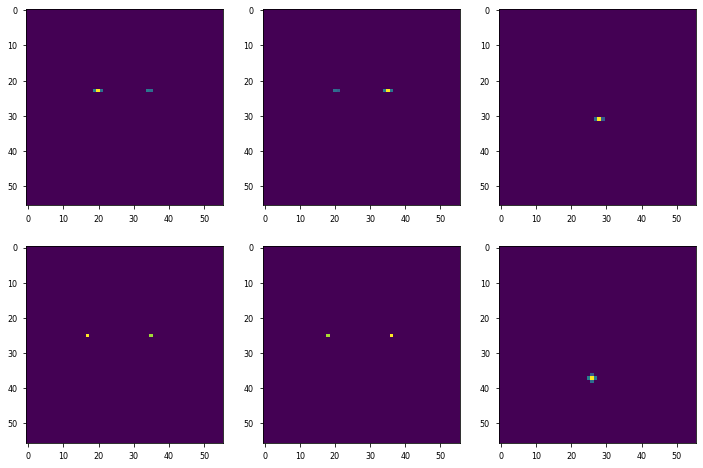

In [10]:
# show templates
n_templates = np.shape(fr_templates)[-1]

plt.figure(figsize=(n_templates * 4, n_training * 4))
for i in range(n_training):
    for j in range(n_templates):
        plt.subplot(n_training, n_templates, i * n_templates + j + 1)
        plt.imshow(fr_templates[i, ..., j])

### patch images (Transformers trick)

In [11]:
# split in patches
def pred_to_patch(pred, patch_size=8):
    pred = np.expand_dims(pred, axis=[0, 3])
    patches = tf.image.extract_patches(
        images=pred,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()
    return patches

In [12]:
def get_patches_centers(patches, patch_size=8, verbose=False):
    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                CoA = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([CoA[0] + j*patch_size, CoA[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    return centers, max_patch

In [13]:
def get_activity_from_patterns(preds, patterns, rbf_templates, threshold_val=0.25, face_pos_offset=None, face_x_scales=None, verbose=False, do_plot=False):
    templates = []
    for p, pattern in enumerate(patterns):
        _preds = np.expand_dims(preds, axis=0)
        _preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[p]), axis=0)
        template = pattern.transform(_preds, face_x_scales=face_x_scales)

        if verbose:
            print("[Pattern] max value found on pattern {}: {}".format(p, np.max(template, axis=(0, 1, 2))))

        # apply threshold
        template[template < threshold_val] = 0
        templates.append(template)

        if do_plot:
            n_templates = np.shape(template)[-1]
            plt.figure(figsize=(n_templates * 4, 4))
            for i in range(n_templates):
                plt.subplot(1, n_templates, i+1)
                plt.imshow(template[0, ..., i], cmap='Greys')
                plt.title("Activity template {}".format(i))

    # concatenate all templates
    _templates = np.array(templates[0])
    for i in range(1, len(patterns)):
        _templates = np.concatenate((_templates, templates[i]), axis=3)

    # get pos for each type
    pos_dict = {}
    n_entry = 0
    for i in range(np.shape(_templates)[-1]):
        patches = pred_to_patch(_templates[0, ..., i])
        positions, max_values = get_patches_centers(patches)

        for pos, max_val in zip(positions, max_values):
            pos_dict[n_entry] = {'type': i, 'pos': pos, 'max': max_val}
            n_entry += 1

    return pos_dict

In [14]:
def get_lmk(preds, patterns, rbf_templates, face_x_scales=None, verbose=False, do_plot=False):
    # compute fr lmk activity
    lmks = []
    for i in range(np.shape(preds)[0]):
        lmk = get_activity_from_patterns(preds[i], patterns, rbf_templates, face_x_scales=face_x_scales, verbose=verbose, do_plot=do_plot)
        lmks.append(lmk)

        if verbose:
            for j in range(len(lmk)):
                print("[LMK] {}) {}".format(j, lmk[j]))
            print()

    return lmks

In [15]:
fr_lmks = get_lmk(preds, fr_patterns, rbf_fr_templates, verbose=True)

[Pattern] max value found on pattern 0: [1. 1. 1.]
[Pattern] max value found on pattern 1: [0.    0.002 0.151]
[LMK] 0) {'type': 0, 'pos': [19.966002783255732, 22.99997534001919], 'max': 1.0}
[LMK] 1) {'type': 0, 'pos': [34.475426525860044, 22.99994182717735], 'max': 0.403964835342019}
[LMK] 2) {'type': 1, 'pos': [20.45619876840451, 22.99993346904182], 'max': 0.36614783330580697}
[LMK] 3) {'type': 1, 'pos': [34.986463522520104, 22.999975279613732], 'max': 1.0}
[LMK] 4) {'type': 2, 'pos': [27.95523490598333, 30.999972659279432], 'max': 1.0}

[Pattern] max value found on pattern 0: [0.053 0.033 0.09 ]
[Pattern] max value found on pattern 1: [1. 1. 1.]
[LMK] 0) {'type': 3, 'pos': [16.99999360004096, 24.99999360004096], 'max': 1.0}
[LMK] 1) {'type': 3, 'pos': [34.99997756107178, 24.99999252035726], 'max': 0.8556494411518196}
[LMK] 2) {'type': 4, 'pos': [17.99998534290134, 24.99999267145067], 'max': 0.8732905802465699}
[LMK] 3) {'type': 4, 'pos': [35.999974400163836, 24.99999360004096], 'ma

#### Helper to fine-tune sigma of FR LMK

In [16]:
# # fine tune FR lmks
# config['louise_rbf_FR_sigma'] = [1600, 1600, 1600]
# config['merry_rbf_FR_sigma'] = [1600, 1600, 1600]
# fr_templates,  rbf_fr_templates, fr_patterns = get_templates(preds, sigmas, rbfs, verbose=True)
# fr_lmks = get_lmk(preds, fr_patterns, rbf_fr_templates, verbose=True)

### Get identity (Max pooling)

In [17]:
def max_pool_activity(activity_dict, dist_threshold=2, sorting='max', verbose=False):
    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(activity_dict)):
        for p_a in range(p_t + 1, len(activity_dict)):  # only upward diagonal
            # get primers
            p_target = activity_dict[p_t]
            p_agent = activity_dict[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance between {} ({}-{}) and {} ({}-{}): {}".format(p_t, p_target["type"], p_target["max"], p_a, p_agent["type"], p_agent["max"], distance))

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] >= p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                        if verbose:
                            print("discarded agent primer", p_a)
                    else:
                        discarded_primer_idx.append(p_t)
                        if verbose:
                            print("discarded target primer", p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in activity_dict:
        if p not in discarded_primer_idx:
            primer = activity_dict[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [18]:
def max_pool_lmks(fr_lmks, verbose=False):
    # pool fr lmks (max activation)
    fr_lmks_pooled = []
    for i in range(np.shape(fr_lmks)[0]):
        fr_lmk_pooled = max_pool_activity(fr_lmks[i], verbose=verbose)
        fr_lmks_pooled.append(fr_lmk_pooled)

        if verbose:
            print("[FR] len fr_lmk_pooled", len(fr_lmk_pooled))
            for j in range(len(fr_lmk_pooled)):
                print("[FR LMK] {}) fer_lmk: {}".format(j, fr_lmk_pooled[j]))
            print()
    return fr_lmks_pooled

In [19]:
fr_lmks_pooled = max_pool_lmks(fr_lmks, verbose=True)

distance between 0 (0-1.0) and 1 (0-0.403964835342019): 14.509423742643015
distance between 0 (0-1.0) and 2 (1-0.36614783330580697): 0.4901959869370194
discarded agent primer 2
distance between 0 (0-1.0) and 3 (1-1.0): 15.020460739264372
distance between 0 (0-1.0) and 4 (2-1.0): 11.3060951269213
distance between 1 (0-0.403964835342019) and 2 (1-0.36614783330580697): 14.019227757458028
distance between 1 (0-0.403964835342019) and 3 (1-1.0): 0.5110369977549568
discarded target primer 1
distance between 1 (0-0.403964835342019) and 4 (2-1.0): 10.320532548008098
distance between 2 (1-0.36614783330580697) and 3 (1-1.0): 14.53026475417575
distance between 2 (1-0.36614783330580697) and 4 (2-1.0): 10.965225489612639
distance between 3 (1-1.0) and 4 (2-1.0): 10.6507339621579
discarded primers
[2, 1]
[FR] len fr_lmk_pooled 3
[FR LMK] 0) fer_lmk: {'type': 0, 'pos': [19.966002783255732, 22.99997534001919], 'max': 1.0}
[FR LMK] 1) fer_lmk: {'type': 1, 'pos': [34.986463522520104, 22.999975279613732],

### Classification of Facial Identities Recognition

In [20]:
def get_type(activity_dict, verbose=False):
    # declare variables
    type_counters = [0, 0, 0]
    positions = []
    right_eye_pos = None
    left_eye_pos = None
    nose_pos = None

    for i in activity_dict:
        if verbose:
            print("activity dict:", activity_dict[i])
        dict = activity_dict[i]

        # count types
        if dict['type'] in [0, 1, 2]:
            type_counters[0] += 1
        elif dict['type'] in [3, 4, 5]:
            type_counters[1] += 1
        elif dict['type'] in [6, 7, 8]:
            type_counters[2] += 1

        # get positions of types
        if dict['type'] in [0, 3, 6]:
            right_eye_pos = dict['pos']
        elif dict['type'] in [1, 4, 7]:
            left_eye_pos = dict['pos']
        elif dict['type'] in [2, 5, 8]:
            nose_pos = dict['pos']
        else:
            print("dict type ({}) not found!".format(dict['type']))

        positions.append(dict['pos'])

    if verbose:
        print("types:", type_counters)
        print("positions")
        print(positions)

    bfs_type = np.argmax(type_counters)
    if len(positions) != 0:
        mean_pos = np.mean(positions, axis=0)
    else:
        print("No landmarks have been found! Please re-consider your threshold value")
        mean_pos = None

    if left_eye_pos and right_eye_pos is not None:
        width = left_eye_pos[0] - right_eye_pos[0]
    else:
        width = None

    if nose_pos and left_eye_pos and right_eye_pos is not None:
        height = nose_pos[1] - np.amin([left_eye_pos[1], right_eye_pos[1]])
    else:
        height = None

    return bfs_type, mean_pos, [width, height]

In [21]:
def get_face_pos_scales(lmks_pooled, verbose=False):
    face_types = []
    face_poses = []
    face_sizes = []
    for i in range(np.shape(lmks_pooled)[0]):
        face_type, face_pos, face_size = get_type(lmks_pooled[i], verbose=verbose)
        face_types.append(face_type)
        face_poses.append(face_pos)
        face_sizes.append(face_size)

        if verbose:
            print("Face type:", face_type)
            print("Face pos:", face_pos)
            print("face size:", face_size)
            print()

    return face_types, face_poses, face_sizes

In [22]:
fr_face_types, fr_face_poses, fr_face_sizes = get_face_pos_scales(fr_lmks_pooled, verbose=True)
print("fr_face_types:", fr_face_types)
print("fr_face_poses:", fr_face_poses)
print("fr_face_sizes:", fr_face_sizes)

activity dict: {'type': 0, 'pos': [19.966002783255732, 22.99997534001919], 'max': 1.0}
activity dict: {'type': 1, 'pos': [34.986463522520104, 22.999975279613732], 'max': 1.0}
activity dict: {'type': 2, 'pos': [27.95523490598333, 30.999972659279432], 'max': 1.0}
types: [3, 0, 0]
positions
[[19.966002783255732, 22.99997534001919], [34.986463522520104, 22.999975279613732], [27.95523490598333, 30.999972659279432]]
Face type: 0
Face pos: [27.636 25.667]
face size: [15.020460739264372, 7.9999973796657]

activity dict: {'type': 3, 'pos': [16.99999360004096, 24.99999360004096], 'max': 1.0}
activity dict: {'type': 4, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
activity dict: {'type': 5, 'pos': [25.99452501418851, 37.02738211293368], 'max': 1.0}
types: [0, 3, 0]
positions
[[16.99999360004096, 24.99999360004096], [35.999974400163836, 24.99999360004096], [25.99452501418851, 37.02738211293368]]
Face type: 1
Face pos: [26.331 29.009]
face size: [18.999980800122877, 12.02738851289272]

In [23]:
# save reference to face scale to compute x_scales
ref_face_x_scale = np.array(fr_face_sizes)[:, 0]

x_scales = []
for i in range(n_training):
    type = fr_face_types[i]
    x_scales.append(fr_face_sizes[i][0] / ref_face_x_scale[i])

print("x_scales:", x_scales)

x_scales: [1.0, 1.0]


In [24]:
def draw_lmks_on_images(data, lmks):
    # display FR lmks on training img
    img_to_ft_ratio = 224 / 56

    n_images = len(data[0])
    plt.figure(figsize=(4 * n_images, 4))
    plt.suptitle("Landmarks for Facial Recognition on Neutral Pose")
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        img = np.array(data[0][i])
        img = img[..., ::-1]
        img = (np.array(img) + 127.5) / 256

        lmk = lmks[i]
        n_lmk = len(lmk)
        for j in range(n_lmk):
            lmk_pos = np.array(lmk[j]['pos']) * img_to_ft_ratio
            pos_x = int(round(lmk_pos[0]))
            pos_y = int(round(lmk_pos[1]))
            img[(pos_y-1):(pos_y+1), (pos_x-1):(pos_x+1)] = [1, 0, 0]

        plt.imshow(img)
        # plt.imsave("test_0.jpg", img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


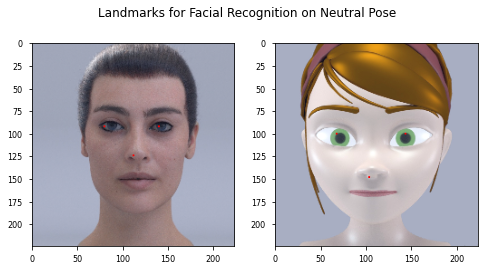

In [25]:
draw_lmks_on_images(data, fr_lmks_pooled)

## FER recognition

In [26]:
ref_sigmas = ['louise_rbf_FER_sigma', 'merry_rbf_FER_sigma']
ref_rbfs = ['louise_rbf_FER_pos', 'merry_rbf_FER_pos']
ref_rbfs_mask = ['louise_rbf_FER_mask', 'merry_rbf_FER_mask']
ref_rbfs_zeros = ['louise_rbf_FER_zeros', 'merry_rbf_FER_zeros']

fer_templates,  rbf_fer_templates, fer_patterns = get_templates(preds,
                                                                ref_sigmas,
                                                                ref_rbfs,
                                                                threshold=0.1,
                                                                masks=ref_rbfs_mask,
                                                                zeros=ref_rbfs_zeros,
                                                                verbose=True)

[PATTERN] Fit pattern
[PATTERN] fit pattern: use mask ON
[PATTERN] Fit pattern
[PATTERN] fit pattern: use mask ON
[RBF] shape templates (2, 56, 56, 10)
[RBF] Shape rbf_templates (2, 10, 2, 2)


shape fer_templates (2, 56, 56, 10)


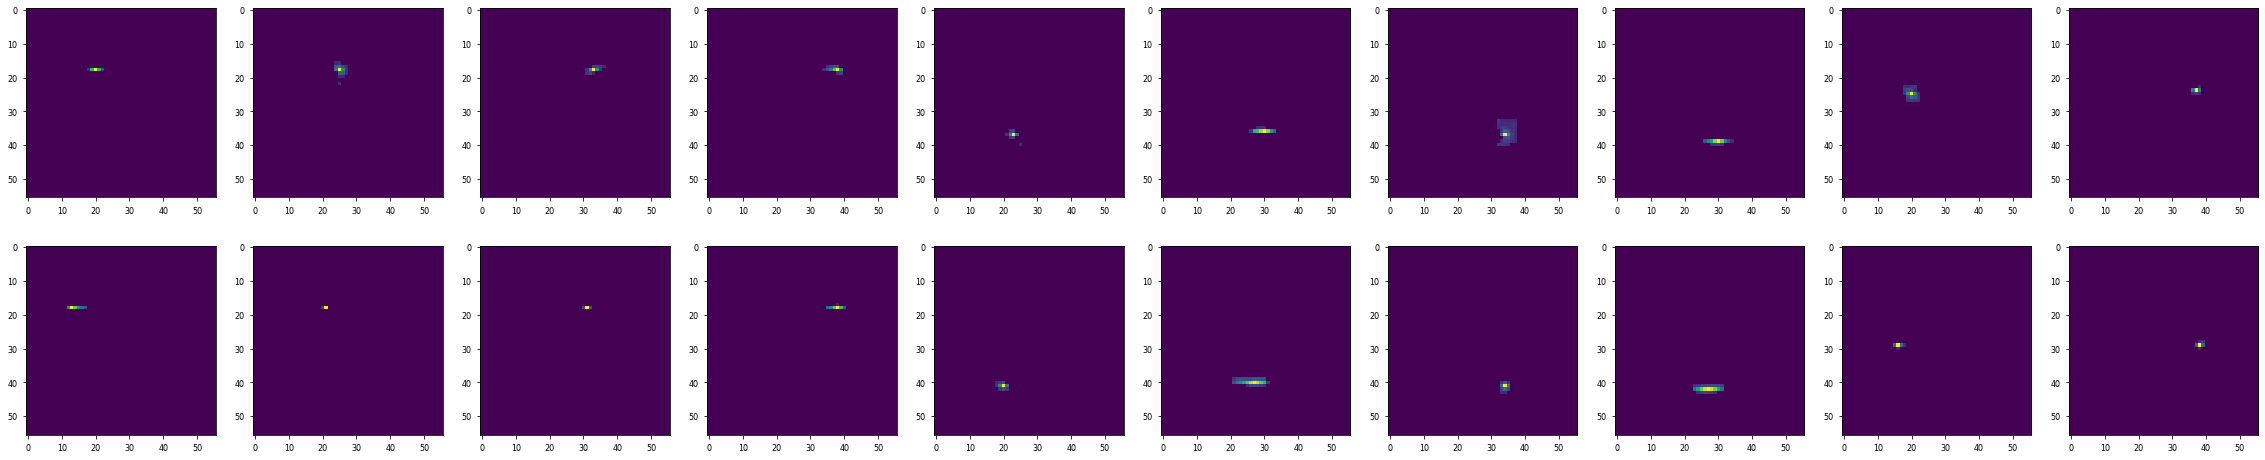

In [27]:
# show fer templates
print("shape fer_templates", np.shape(fer_templates))
n_templates = np.shape(fer_templates)[-1]

plt.figure(figsize=(n_templates * 4, n_training * 4))
for i in range(n_training):
    for j in range(n_templates):
        plt.subplot(n_training, n_templates, i * n_templates + j + 1)
        plt.imshow(fer_templates[i, ..., j])

In [28]:
def get_FER_lmks_pos(preds, face_types, patterns, rbf_templates):
    fer_lmks_pos = []
    # get positions of the activity map
    for i in range(len(preds)):
        # get activity index per head type (identity)
        face_type = face_types[i]

        # expand dims to fit the transform requirements
        template_preds = np.repeat(np.expand_dims(preds[i], axis=0), 1, axis=0)
        template_preds = np.repeat(np.expand_dims(template_preds, axis=0), len(rbf_templates[face_type]), axis=0)

        # get template activity
        template = patterns[face_type].transform(template_preds, face_x_scales=[x_scales[face_type]])
        template[template < 0.1] = 0

        # compute position
        pos = calculate_position(template, mode="weighted average", return_mode="xy float flat")
        fer_lmks_pos.append(pos)

    return np.squeeze(fer_lmks_pos)

In [29]:
fer_lmks_pos = get_FER_lmks_pos(preds, fr_face_types, fer_patterns, rbf_fer_templates)
print("shape fer_lmks_pos", np.shape(fer_lmks_pos))

shape fer_lmks_pos (2, 20)


In [30]:
def draw_fer_lmks_on_images(data, lmk_pos, flat=True):
    # plot landmarks on images
    img_to_ft_ratio = 224 / 56
    if flat:
        # reshape fer_lmks
        lmk_pos = np.reshape(lmk_pos, (len(lmk_pos), -1, 2))

    n_images = len(data[0])
    plt.figure(figsize=(4 * n_images, 4))
    plt.suptitle("Landmarks for Facial Recognition on Neutral Pose")
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        img = np.array(data[0][i])
        img = img[..., ::-1]
        img = (np.array(img) + 127.5) / 256

        lmk = lmk_pos[i]
        n_lmk = len(lmk)
        for j in range(n_lmk):
            pos = lmk[j] * img_to_ft_ratio
            pos_x = int(round(pos[1]))
            pos_y = int(round(pos[0]))
            img[(pos_y-1):(pos_y+1), (pos_x-1):(pos_x+1)] = [1, 0, 0]

        plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


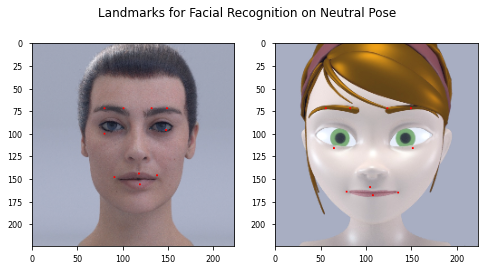

In [31]:
draw_fer_lmks_on_images(data, fer_lmks_pos)

# Train Norm-referenced encoding

### get training set on Louise

In [32]:
# load the training data to train ref and tuning vectors: Louise all expressions
config['train_avatar'] = 'Louise'
config['train_expression'] = ['full']
data = load_data(config)
n_training = len(data[0])
print("[LOAD] Training Data loaded", np.shape(data[0]))
print("[LOAD] Labels Data loaded", np.shape(data[1]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 7/7 [00:00<00:00, 171.41it/s]

[LOAD] Training Data loaded (7, 224, 224, 3)
[LOAD] Labels Data loaded (7,)



In [33]:
def compute_face_pos_and_scales(types, faces_pos, faces_size, verbose=False):
    x_pos_offset = []
    x_scales_offset = []

    for i in range(len(types)):
        type = types[i]

        try:
            x_scales_offset.append(faces_size[i][0] / ref_face_x_scale[type])
        except:
            print("Not able to compute the scale offset for: {}. Set to 1.0".format(faces_size[i][0]))
            x_scales_offset.append(1.0)

    if verbose:
        print("x_scales_offset:", x_scales_offset)
    print("TODO face pos!")

    return x_pos_offset, x_scales_offset

In [34]:
def predict_fer_lmk_pos(data, verbose=False):
    # get preds from VGG
    preds = predict_v4(data)

    # get Facial Recognition landmarks
    fr_lmks = get_lmk(preds, fr_patterns, rbf_fr_templates, verbose=False)
    fr_lmks_pooled = max_pool_lmks(fr_lmks)

    # get face types and pos
    fr_types, fr_faces_pos, fr_faces_size = get_face_pos_scales(fr_lmks_pooled, verbose=False)
    print("fr_types", fr_types)
    print("fr_faces_pos", fr_faces_pos)
    print("fr_faces_size", fr_faces_size)

    # get offset for face pos and scales
    x_pos_offset, face_x_scales = compute_face_pos_and_scales(fr_types, fr_faces_pos, fr_faces_size, verbose=verbose)
    print("x_pos_offset", x_pos_offset)
    print("face_x_scales", face_x_scales)

    # get Facial Expression landmarks
    fer_lmks_pos = get_FER_lmks_pos(preds, fr_types, fer_patterns, rbf_fer_templates)
    print("shape fer_lmks_pos", np.shape(fer_lmks_pos))

    return fer_lmks_pos

In [35]:
fer_pos = predict_fer_lmk_pos(data, verbose=True)
print("fer_pos:", np.shape(fer_pos))

1/1 [==============================] - 0s 30ms/step
[TRAIN] shape prediction (7, 56, 56, 256)
shape eyebrow semantic feature selection (7, 56, 56, 2)
shape lips semantic feature selection (7, 56, 56, 16)
[TRAIN] shape preds (7, 56, 56, 18)
No landmarks have been found! Please re-consider your threshold value
No landmarks have been found! Please re-consider your threshold value
fr_types [0, 0, 0, 0, 0, 0, 0]
fr_faces_pos [array([27.636, 25.667]), array([27.698, 25.667]), None, array([27.684, 31.   ]), array([27.553, 25.61 ]), array([27.534, 25.667]), None]
fr_faces_size [[15.020460739264372, 7.9999973796657], [15.10975728512022, 7.999990425537472], [None, None], [None, None], [14.653454131242562, 8.169929251978438], [14.919314678506254, 7.999988923290026], [None, None]]
Not able to compute the scale offset for: None. Set to 1.0
Not able to compute the scale offset for: None. Set to 1.0
Not able to compute the scale offset for: None. Set to 1.0
x_scales_offset: [1.0, 1.0059449937925287, 

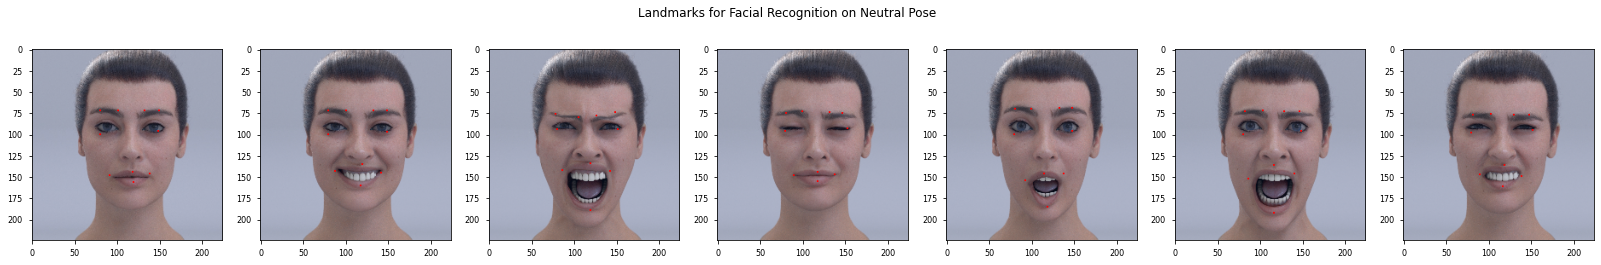

In [37]:
#plot landmarks on images
draw_fer_lmks_on_images(data, fer_pos)

### Train Norm-reference Model

In [41]:
def train_NR_model(fer_pos, verbose=False):
    # declare a model to access its functions and train it
    nre_model = NormBase(config, tuple(config['input_shape']))
    nre_model.n_features = np.shape(fer_pos)[-1]
    nre_model.r = np.zeros(nre_model.n_features)  # need to reset the size since initial set it to the size of VGG
    # train manually ref vector
    nre_model._fit_reference([fer_pos, data[1]], config['batch_size'])
    ref_train = np.copy(nre_model.r)
    # train manually tuning vector
    nre_model.t = np.zeros((nre_model.n_category, nre_model.n_features))
    nre_model.t_mean = np.zeros((nre_model.n_category, nre_model.n_features))
    nre_model._fit_tuning([fer_pos, data[1]], config['batch_size'])
    ref_tuning = np.copy(nre_model.t)
    # get it resp
    it_train = nre_model._get_it_resp(fer_pos)

    if verbose:
        print("[NRE Training] shape fer_pos", np.shape(fer_pos))
        print("[TRAIN] model.r", np.shape(nre_model.r))
        print("[TRAIN] shape it_train", np.shape(it_train))
        print(it_train)

    return nre_model, it_train


In [42]:
nre_model, nre_pred = train_NR_model(fer_pos, verbose=True)

nu missing from json configuration file! Set to '2.0'
tuning_function missing from json configuration file! Set to '2-norm'
1 Physical GPUs, 1 Logical GPUs

[INIT] -- Model loaded --
[INIT] Extraction Model: VGG19
[INIT] V4 layer: block3_conv3
[INIT] shape_v4 (None, 56, 56, 256)
[INIT] n_features: 802816
[INIT] Neutral threshold (2.0%): 16056.32

[FIT] Learning reference pattern


100%|██████████| 1/1 [00:00<00:00, 9000.65it/s]


[FIT] Learning tuning vector
shape self.t (7, 20)
shape self.t_mean (7, 20)
shape self.t_cumul (7,)


100%|██████████| 1/1 [00:00<00:00, 1995.39it/s]

[NRE Training] shape fer_pos (7, 20)
[TRAIN] model.r (20,)
[TRAIN] shape it_train (7, 7)
[[0.    0.    0.    0.    0.    0.    0.   ]
 [0.    3.064 0.905 0.    0.02  0.486 1.01 ]
 [0.    2.871 9.72  0.065 4.8   7.653 4.301]
 [0.    0.    0.016 2.438 0.    0.    0.705]
 [0.    0.048 3.646 0.    7.383 5.91  0.164]
 [0.    1.497 7.438 0.    7.562 9.446 2.258]
 [0.    1.251 1.679 1.097 0.084 0.907 3.794]]


# Test Norm-referenced encoding

### Load testing data

In [43]:
# load the training data to train ref and tuning vectors: Louise all expressions
test_data = load_data(config, train=False)
n_test_training = len(test_data[0])
print("[LOAD] Training test_data loaded", np.shape(test_data[0]))
print("[LOAD] Labels test_data loaded", np.shape(test_data[1]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 7/7 [00:00<00:00, 217.28it/s]

[LOAD] Training test_data loaded (7, 224, 224, 3)
[LOAD] Labels test_data loaded (7,)

